In [1]:
import pandas as pd
import numpy as np

# Etude protocole 2

In [2]:
df = pd.read_csv('../Clean_Dataset/df_protocole_2_v2.csv', low_memory=False, index_col=0)

In [3]:
from collections import Counter

In [4]:
counts = df.individu_id.groupby(by=df.individu_id).count()
cunter = Counter(counts.values)

In [5]:
df['solde_std_0'].isna().sum()

0

## Reduce feature size

In [6]:
menage_features = [c for c in df.columns if not ord('0')<= ord(c[-1]) <= ord('9')]

In [7]:
df_numerical_menage_features = df[menage_features]._get_numeric_data()
numerical_menage_features = list(df_numerical_menage_features.columns.values)
numerical_menage_features.remove('nan_solde_count')


In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

<AxesSubplot:>

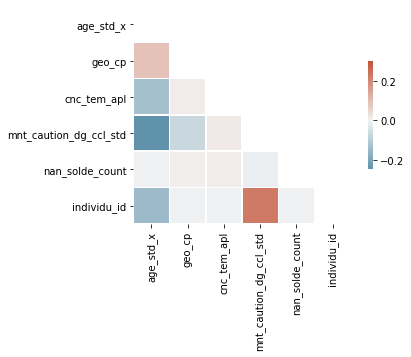

In [9]:
fig, ax = plt.subplots()
cmap = sns.diverging_palette(230, 20, as_cmap=True)
corr = df_numerical_menage_features.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Les correlations sont assez faibles, donc on choisit de ne pas enlever de composant.

In [10]:
df_temp_numerical = df[[c for c  in df.columns if c not in menage_features]]._get_numeric_data()

In [11]:
temp_numerical_features = df_temp_numerical.columns

<AxesSubplot:>

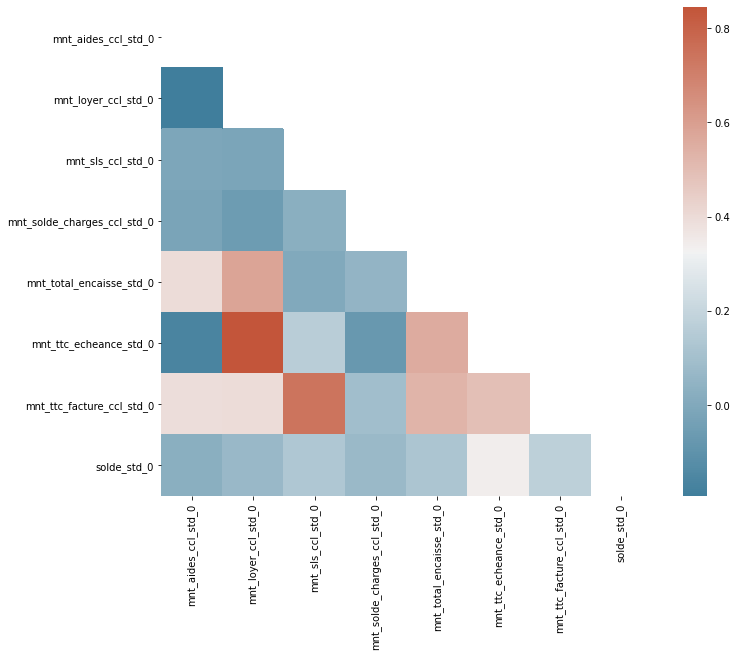

In [12]:
fig, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
corr = df_temp_numerical[[c for c in df_temp_numerical if '_0' in c]].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap=cmap)

Les colonnes nb_seul_std, mnt_ttc_facture_ccl_std_ vont être écarté car ont trop de corrélation avec d'autres variables

In [13]:
## selection des mois de -n à -k

def get_str_num(s):
    n = s.split('_')[-1]
    if n[-1].isdigit():
        return int(n)
    

def get_feature_and_months_col(columns: list, m_min: int, m_max: int, target: str):
    assert m_min < m_max, 'the first month should be smaller than the last'
    
    features = [c for c in columns if c==target or get_str_num(c)!=None and m_min<=get_str_num(c)<=m_max ]
    
    return features
    

In [14]:

m_min=-3
m_max=0
target = "solde_std_1"
is_correlated = lambda c: any(s in c for s in ['nb_seul_std', 'mnt_ttc_facture_ccl_std_'])
past_features = get_feature_and_months_col([f for f in temp_numerical_features if not is_correlated(f)], m_min, m_max, target)
df_past = df[past_features + ['individu_id']]

In [15]:
df_past.dropna(
    axis=0,
    #thresh=0,
    subset=[c for c in df_past.columns if 'solde_std' in c],
    inplace=True
)

/home/pier/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [16]:
df_numerical_menage_features = df[numerical_menage_features].groupby('individu_id').first()

In [17]:
df_past_numerical = pd.merge(
    df_past,
    df_numerical_menage_features,
    on='individu_id',
    suffixes=('','_y')
)


## Plot correlations with temporal features

In [18]:
for i in range(m_min, m_max,-1): # remove -1 to run
    fig, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    corr = df_past[[c for c in df_past.columns if str(i)in c]].corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
                square=True)

## deal with missing values

In [23]:
sum_nan = df_past_numerical.isna().sum()
max_sum = max(sum_nan.values)
sum_nan.values/len(df_past_numerical)

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.43065059e-05,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.83349625e-01,
       0.00000000e+00, 0.00000000e+00])

In [24]:
col_with_data = [c for c in df_past_numerical.columns if sum_nan[c]/max_sum < .93]

In [25]:
df_past_numerical_data = df_past_numerical[col_with_data]

In [26]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


In [27]:
features = [c for c in df_past_numerical_data.columns if c!=target]
X = df_past_numerical_data[features]
y = df_past_numerical_data[target]

In [28]:
imp = IterativeImputer(max_iter=10, random_state=0)
X_imp = imp.fit_transform(X)

## split data

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_imp, y, test_size=0.33, random_state=42)


### calculs des scores de baseline

In [31]:
# base line y_pred = 0

y_base = np.zeros_like(y_test)
print(f'mse_base is {mse(y_base, y_test)}')
print(f'mae_base is {mae(y_base, y_test)}')

mse_base is 361406.74711347703
mae_base is 130.25297679776207


In [32]:
# base line y_pred = median y_train

y_base = np.zeros_like(y_test) + np.median(y_train)
print(f'mse_base is {mse(y_base, y_test)}')
print(f'mae_base is {mae(y_base, y_test)}')

mse_base is 361406.74711347703
mae_base is 130.25297679776207


In [33]:
# base line y_pred = mean y_train

y_base = np.zeros_like(y_test) + np.mean(y_train)
print(f'mse_base is {mse(y_base, y_test)}')
print(f'mae_base is {mae(y_base, y_test)}')

mse_base is 353867.31370772497
mae_base is 202.17165987414836


## entrainement des modèles

In [34]:
reg = LinearRegression().fit(X_train, y_train)

In [35]:
y_pred = reg.predict(X_test)
print(f'mse is {mse(y_pred, y_test)}')
print(f'mae is {mae(y_pred, y_test)}')

mse is 26984.50857993098
mae is 54.68485719316951


Text(0.5, 0, '% erreur sur solde_std_1')

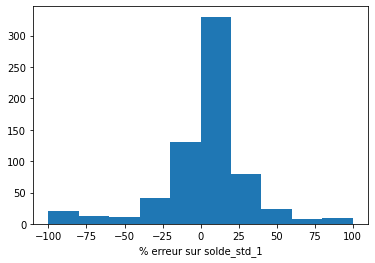

In [36]:
fig, ax = plt.subplots()
mask1 = y_test>0
mask2 = y_pred>0
mask = mask1 & mask2
ax.hist(100*(y_test[mask]/y_pred[mask] - 1), density=False, log=False, range=(-100, 100))
ax.set_xlabel('% erreur sur '+target)

In [37]:
from sklearn.linear_model import LassoCV

In [38]:
reg = LassoCV().fit(X_train, y_train)
y_pred = reg.predict(X_test)

mse is 31618.918708307072
mae is 54.772202928635174


Text(0.5, 0, '% erreur sur solde_std_1')

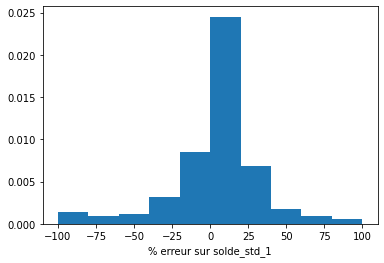

In [39]:
print(f'mse is {mse(y_pred, y_test)}')
print(f'mae is {mae(y_pred, y_test)}')
fig, ax = plt.subplots()
mask1 = y_test>0
mask2 = y_pred>0
mask = mask1 & mask2
ax.hist(100*(y_test[mask]/y_pred[mask] - 1), density=True, log=False, range=(-100, 100))
ax.set_xlabel('% erreur sur '+target)

In [40]:
df_lasso_coefs = pd.DataFrame(
data={
    "columns": list(X.columns.values),
    "_coefs": list(reg.coef_)
})

### Selection des features avec Lasso
; 
16 features ont été seletionné au travers de la procedure lasso. On observe que les features importantes sont celles liées à la tenue de compte et non la composition du ménage.

In [41]:
lasso_cols = df_lasso_coefs[np.abs(df_lasso_coefs._coefs)>0.005]['columns'].unique()
df_lasso_coefs[np.abs(df_lasso_coefs._coefs)>0.005].sort_values(by='columns')

,columns,_coefs
2,mnt_aides_ccl_std_-1,0.301786
1,mnt_aides_ccl_std_-2,0.115907
0,mnt_aides_ccl_std_-3,0.023052
3,mnt_aides_ccl_std_0,0.554735
31,mnt_caution_dg_ccl_std,0.072788
6,mnt_loyer_ccl_std_-1,0.078100
10,mnt_sls_ccl_std_-1,0.062479
11,mnt_sls_ccl_std_0,0.282901
18,mnt_total_encaisse_std_-1,-0.306914
17,mnt_total_encaisse_std_-2,-0.053211


In [46]:
year_nb = set()
titles = set()
for col in lasso_cols:
    words = col.split('_')
    month = words[-1]
    try:
        month = int(month)
        year_nb.add(month)
        titles.add('_'.join(words[:-1]))
    except ValueError as e:
        pass


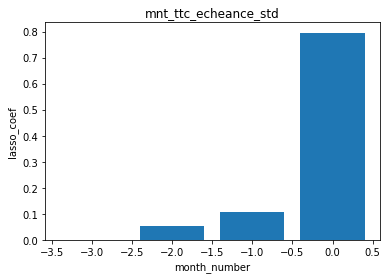

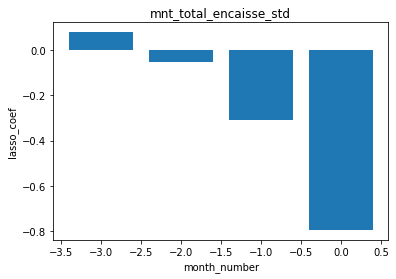

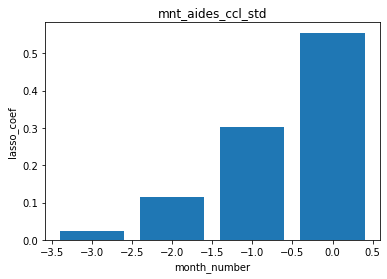

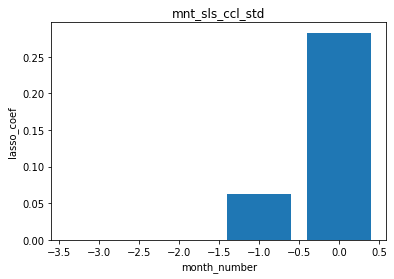

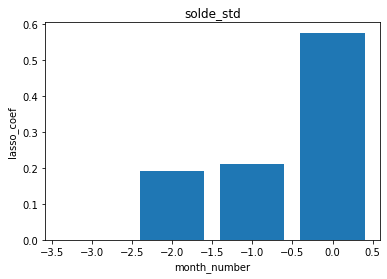

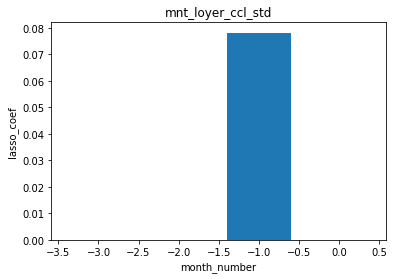

In [48]:
for title in titles:
    coefs = np.zeros(len(year_nb))
    for year in year_nb:
        col = f'{title}_{year}'
        coefs[-int(year)] = df_lasso_coefs[df_lasso_coefs['columns']==col]['_coefs']
    fig, ax = plt.subplots()
    ax.bar(x=np.arange(len(coefs))*(-1), height=coefs)
    ax.set_xlabel('month_number')
    ax.set_ylabel('lasso_coef')
    ax.set_title(title)
        


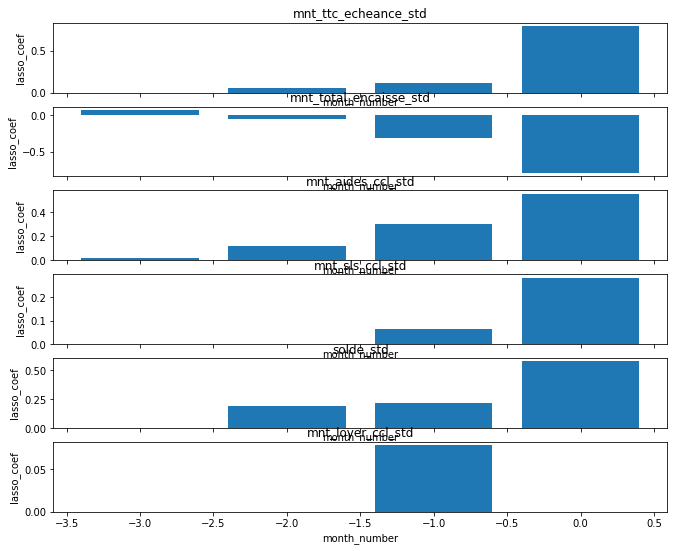

In [51]:
fig, ax = plt.subplots(len(titles),1, sharex=True, figsize=(11, 9))

for i, title in enumerate(titles):
    coefs = np.zeros(len(year_nb))
    for year in year_nb:
        col = f'{title}_{year}'
        coefs[-int(year)] = df_lasso_coefs[df_lasso_coefs['columns']==col]['_coefs']
    ax[i].bar(x=np.arange(len(coefs))*(-1), height=coefs)
    ax[i].set_xlabel('month_number')
    ax[i].set_ylabel('lasso_coef')
    ax[i].set_title(title)
        

In [52]:

df_for_plt = pd.DataFrame(data={
    'title': [tout for t in titles for tout in [t]*len(year_nb)],
    'month': [i for _ in [0]*len(titles) for i in np.arange(len(year_nb))*(-1) ],
    'coef': [df_lasso_coefs[df_lasso_coefs['columns']==t+'_'+str(m)]['_coefs'].values[0] for t in titles for m in reversed(sorted([int(y) for y in year_nb]))]
})

<AxesSubplot:xlabel='month', ylabel='coef'>

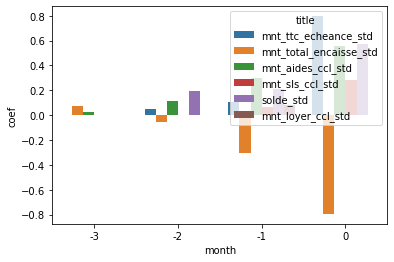

In [53]:
sns.barplot(data=df_for_plt, hue='title', x='month', y='coef', ci=None)

In [54]:
df_for_plt['coef'] = df_lasso_coefs[df_lasso_coefs['columns']==df_for_plt['title']+'_'+df_for_plt['month']]['_coefs']

TypeError: must be str, not int

On peut donc voir que ce sont les mois les plus récents qui sont les plus importants pour prédire le solde dans le futur.